In [86]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from MakeData import make_data
import matplotlib.pyplot as plt
from datetime import datetime

In [78]:
class MyDataSet(Dataset):
    def __init__(self, features_path, labels_path, trans=None, target_trans=None):
        self.features = np.load(features_path, allow_pickle=True)
        self.labels = np.load(labels_path, allow_pickle=True)
        self.trans = trans
        self.target_trans = target_trans

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        feature, label = self.features[item], self.labels[item]
        if self.trans:
            feature = self.trans(feature)
        if self.target_trans:
            label = self.target_trans(label)
        return feature, label


def my_trans(x):
    return torch.Tensor(x)

train_set = MyDataSet('../../Train/train_features.npy', '../../Train/train_labels.npy',
                      trans=my_trans, target_trans=my_trans)
test_set = MyDataSet('../../Train/test_features.npy', '../../Train/test_labels.npy',
                      trans=my_trans, target_trans=my_trans)
train_loader = DataLoader(train_set, batch_size=10)
test_loader = DataLoader(test_set, batch_size=10)

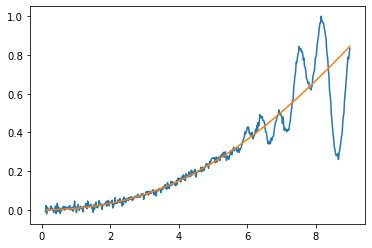

6 512


In [79]:
plt.figure()
feature, label = train_set[1]
x = np.linspace(0.1, 9, 512)
plt.plot(x, feature)
plt.plot(x, np.poly1d([*label, 0])(x/9))
plt.show()
print(len(label), len(feature))

In [80]:
class LK(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(512, 200)
        self.activation1 = torch.nn.Tanh()
        self.l2 = nn.Linear(200, 6)
        self.activation2 = torch.nn.Tanh()

    def forward(self, x):
        x = self.l1(x)
        x = self.activation1(x)
        x = self.l2(x)
        x = self.activation2(x)
        return x

my_model = LK()

print('parameters:')
for pa in my_model.parameters():
    print(pa)

parameters:
Parameter containing:
tensor([[-0.0379, -0.0198, -0.0357,  ...,  0.0199, -0.0157, -0.0287],
        [-0.0273,  0.0323, -0.0265,  ..., -0.0299, -0.0329, -0.0055],
        [-0.0259,  0.0201, -0.0065,  ..., -0.0361,  0.0314, -0.0181],
        ...,
        [-0.0223, -0.0101, -0.0237,  ...,  0.0057, -0.0042,  0.0300],
        [-0.0331, -0.0031,  0.0188,  ...,  0.0053, -0.0211,  0.0162],
        [ 0.0251, -0.0186,  0.0310,  ...,  0.0125, -0.0421, -0.0229]],
       requires_grad=True)
Parameter containing:
tensor([-4.0587e-02, -2.4348e-02,  3.0179e-02,  2.7103e-02,  4.0094e-02,
        -3.5012e-03,  4.3949e-02, -4.0510e-02, -2.5836e-02,  1.2521e-02,
        -1.6310e-02,  2.7235e-02, -1.0115e-02, -3.0863e-02, -3.8833e-02,
         1.1541e-03, -2.0373e-02,  7.7300e-03, -3.8295e-02, -2.5206e-03,
         2.5734e-03, -4.3321e-02,  2.3317e-03,  1.3473e-02, -2.5214e-03,
        -3.5484e-02,  1.7507e-02,  3.0126e-02, -1.5978e-02,  1.8129e-02,
        -3.4091e-02, -3.8203e-03,  1.9220e-03

In [81]:
loss_fn = torch.nn.MSELoss()
feature, label = train_set[1]
outputs = label + 2

print(f'train label:\n{label}\n')
print(f'loss:\n{loss_fn(outputs, label)}')
print(f'loss:\n{loss_fn(label, label)}')

train label:
tensor([ 0.1126, -0.2156, -0.2872,  0.7750,  0.4384,  0.0217])

loss:
4.0
loss:
0.0


In [82]:
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.002, momentum=0.9)

In [83]:
def train_one_epoch(epoch_index, writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        input, label = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        output = my_model(input)

        # Compute the loss and its gradients
        loss = loss_fn(output, label)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch

            loss_x = epoch_index * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, loss_x)

            running_loss = 0.

    return last_loss

In [84]:
from torch.utils.tensorboard import SummaryWriter
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'../logs/{timestamp}')

epoch_number = 0
EPOCHS = 1000

best_vloss = 1e-3

for epoch in range(EPOCHS):
    # Make sure gradient tracking is on, and do a pass over the data
    my_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    my_model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = my_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    if epoch_number % 5 == 4:
        print(f'EPOCH {epoch_number + 1}:')
        print(f'LOSS train {avg_loss: .4f} valid {avg_vloss: .4f}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' :avg_loss, 'Validation': avg_vloss},
                    epoch_number + 1)
    writer.flush()

    epoch_number += 1
    if avg_loss < best_vloss:
        break

EPOCH 5:
LOSS train  0.1743 valid  0.2803
EPOCH 10:
LOSS train  0.1707 valid  0.2754
EPOCH 15:
LOSS train  0.1673 valid  0.2708
EPOCH 20:
LOSS train  0.1633 valid  0.2653
EPOCH 25:
LOSS train  0.1597 valid  0.2600
EPOCH 30:
LOSS train  0.1568 valid  0.2560
EPOCH 35:
LOSS train  0.1544 valid  0.2526
EPOCH 40:
LOSS train  0.1527 valid  0.2501
EPOCH 45:
LOSS train  0.1515 valid  0.2485
EPOCH 50:
LOSS train  0.1507 valid  0.2474
EPOCH 55:
LOSS train  0.1501 valid  0.2466
EPOCH 60:
LOSS train  0.1496 valid  0.2461
EPOCH 65:
LOSS train  0.1492 valid  0.2458
EPOCH 70:
LOSS train  0.1487 valid  0.2458
EPOCH 75:
LOSS train  0.1484 valid  0.2458
EPOCH 80:
LOSS train  0.1480 valid  0.2458
EPOCH 85:
LOSS train  0.1477 valid  0.2457
EPOCH 90:
LOSS train  0.1474 valid  0.2456
EPOCH 95:
LOSS train  0.1472 valid  0.2455
EPOCH 100:
LOSS train  0.1469 valid  0.2453
EPOCH 105:
LOSS train  0.1467 valid  0.2451
EPOCH 110:
LOSS train  0.1464 valid  0.2449
EPOCH 115:
LOSS train  0.1462 valid  0.2448
EPOCH 12

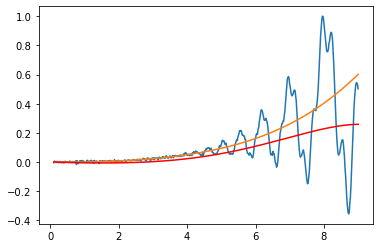

6 512


In [117]:
feature, a1, a2, label = make_data(x, f_num=2, poly_order=6,
         rdio=[1, 2],f_range=[[50, 60],[150, 250]],
         m_range=[0.4, 0.8], t_range=[1, 2], td_range=[2, 4])
feature, label = torch.Tensor(feature), torch.Tensor(label)
label_pre = my_model(feature)

plt.figure()
x = np.linspace(0.1, 9, 512)
plt.plot(x, feature)
plt.plot(x, np.poly1d([*label, 0])(x/9))
plt.plot(x, np.poly1d(np.append(label_pre.detach().numpy(), 0))(x/9), c='r')
plt.show()
print(len(label), len(feature))

In [91]:
len(feature)


512